In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
from scipy.ndimage.filters import gaussian_filter
from scipy.io import loadmat
from functions import *

%matplotlib inline

EEG Curves Data preparation

In [2]:
files = loadmat("dtw_temps.mat")

lda_best_curves = files['mean_curves'].squeeze()
pbtm_temps = files['pbtm_temps'].squeeze()
trg, ntrg = files['trg'].squeeze(), files['ntrg'].squeeze()

trg_x =  np.max(np.abs(trg))
ntrg_x = np.max(np.abs(ntrg))

trg_scaled = trg / trg_x
ntrg_scaled = ntrg / ntrg_x

Source signal for toy dataset

In [3]:
T = 1000

phases = [-12,  -1,  16, -24,  55]
stdevs = [5, 10, 15, 20, 25]
signs = [-1, -1, -1, 1, 1]

#phases = ((np.random.rand(len(signs))-0.5)*120).astype(int)


t = np.arange(T)
s = np.zeros(T)

for ind, it in enumerate(stdevs):
    g = np.roll(gaussian(T, it), phases[ind])
    #plt.plot(g*signs[ind], "gray")
    s = s + g*signs[ind]

#Example signal (pure)
s = s - np.average(s)
s = s / np.max(np.abs(s))


#Noised and filtered signal (so that feature function calculations are more stable)
s_n = add_noise(s)
s_f = gaussian_filter(s_n, 10)

Figure 1: Demonstration of the averaging problem

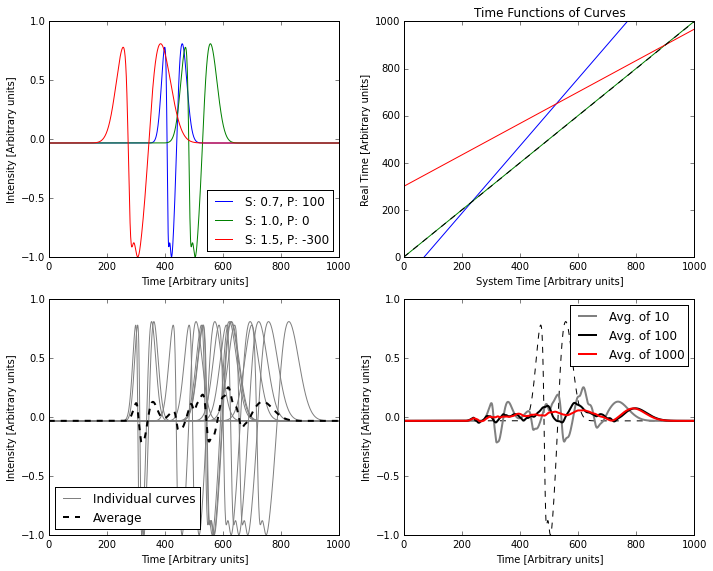

In [18]:
n_curves = 1000
phases = ((np.random.rand(n_curves) - 0.5) * 10).astype(int)
scales = np.random.rand(n_curves) + 0.5
noise_args = {"intensity" : 0.1}
nonlinear_args = {"intensity" : 100, "sf" : 10}

times, curves = create_curves(s, scales, phases) #large numbers of curves

s_, p_ = [0.7, 1, 1.5], [100, 0, -300]
times_ex, curves_ex = create_curves(s, s_, p_) # handpicked examples
plt.figure(figsize = (10, 8))
plt.subplot(221)
plt.plot(curves_ex)
plt.legend(["S: %.1f, P: %d" % (i,j) for i,j in zip(s_, p_)], loc = 4)
plt.xlabel("Time [Arbitrary units]")
plt.ylabel("Intensity [Arbitrary units]")
plt.subplot(222)
plt.plot(times_ex)
plt.plot([0, 1000], [0, 1000], "--", color = "black")
plt.ylim(0, 1000)
plt.xlim(0, 1000)
plt.title("Time Functions of Curves")
plt.xlabel("System Time [Arbitrary units]")
plt.ylabel("Real Time [Arbitrary units]")

plt.subplot(2,2,3)
plt.plot(curves[:, :10], color ="gray")
plt.plot(curves[:, 10], color ="gray", label = "Individual curves")
plt.plot(np.average(curves[:, :10], axis = 1),"--", color = "black", label = "Average", linewidth = 2)
plt.legend(loc = 3)
plt.xlabel("Time [Arbitrary units]")
plt.ylabel("Intensity [Arbitrary units]")
plt.subplot(2,2,4)

plt.plot(s, "--", color = "black")
plt.plot(np.average(curves[:, :10], axis = 1), color = "grey", label = "Avg. of 10",linewidth = 2)
plt.plot(np.average(curves[:, :100], axis = 1), color = "black", label = "Avg. of 100", linewidth = 2)
plt.plot(np.average(curves[:, :1000], axis = 1), color = "red", label = "Avg. of 1000", linewidth = 2)
plt.xlabel("Time [Arbitrary units]")
plt.legend()
plt.ylabel("Intensity [Arbitrary units]")
plt.tight_layout()

plt.savefig("fig1.png")

plt.show()

# Moment Based Alignment

Figure 2: Demonstration of feature functions and moment based alignment results on toy dataset

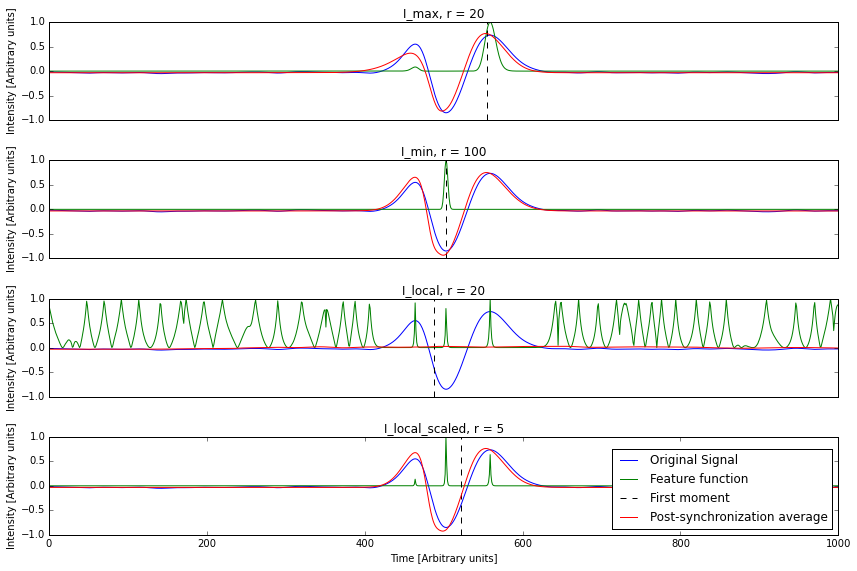

In [16]:

n_curves = 2000
phases = ((np.random.rand(n_curves) - 0.5) * 40).astype(int)
scales = np.random.rand(n_curves) + 0.5

noise_args = {"intensity" : 0.1}
times_ideal, curves_ideal = create_curves(s, scales, phases, noise_args = noise_args)#, nonlinear_args=nonlinear_args)

r_ex = [20, 100, 20, 5]
feat_funcs = [I_max, I_min, I_local, I_local_scaled]
st_smoothing = 5

plt.figure(figsize=(12,8))

for i, func in enumerate(feat_funcs):
    
    plt.subplot(len(feat_funcs), 1, i+1)
    plt.title(func.__name__ + ", r = " + str(r_ex[i]))
    plt.ylim(-1, 1)
    plt.ylabel("Intensity [Arbitrary units]")

    feat_func = func(s_f, r_ex[i])
    moment = get_moment(feat_func, t, 1) * len(t)
    plt.plot(s_f, label = "Original Signal")
    plt.plot(feat_func/np.max(feat_func), label = "Feature function")
    plt.axvline(moment, color = "black", ls = "--", label = "First moment")
    plt.plot(np.average(synchronize(curves_ideal, func, r=r_ex[i], s = True, s_std = st_smoothing)[1], axis = 1),
             linewidth = 1, label = "Post-synchronization average")
    if i < len(feat_funcs)-1:
        plt.xticks([])
        
        #plt.subplot(len(feat_funcs), 1, len(feat_funcs))

plt.xlabel("Time [Arbitrary units]")
plt.legend(loc = 4)        
    
#plt.subplot(515)    
#plt.plot(s_f, "--", color = "black", linewidth = 2, label = "Original signal")    
#plt.plot(np.average(curves_ideal, axis = 1), "--", color = "gray", linewidth = 2, label = "Unsynchronized")
#plt.title("Comparison of averages")
#plt.legend()


plt.tight_layout()
plt.savefig("fig2.png")
plt.show()


Figure 3: Demonstration of MBS on EEG curves

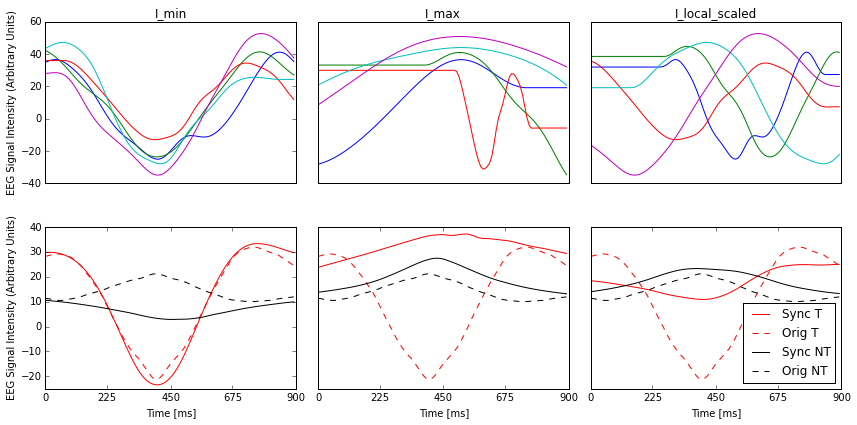

In [13]:

func_list = [I_min, I_max, I_local_scaled]
func_names = ["I_min", "I_max", "I_local_scaled"]
r_list = [20, 100, 5]
plt.figure(figsize = (12, 6))

for i, fun in enumerate(func_list):
    synced_targ = synchronize(trg_scaled, fun, s = True, s_std = 5, r = r_list[i])[1]
    synced_nontarg = synchronize(ntrg_scaled, fun, s = True, s_std = 5, r = r_list[i])[1]
    
    plt.subplot(2, 3, i+1)
    plt.title(func_names[i])
    plt.plot(synced_targ[:, :5]*trg_x)
    plt.xlim(0, synced_targ.shape[0])
    #plt.ylim(-25, 35)
    #plt.xticks(np.linspace(0, synced_targ.shape[0], 5).astype(int), np.linspace(0, 900, 5).astype(int))
    plt.xticks([])
    
    if i == 0:
        plt.ylabel("EEG Signal Intensity (Arbitrary Units)")
    if i!= 0:
        plt.yticks([])
    #plt.xticks(np.round(np.linspace(0, synced_targ.shape[0]+1, len(epo_times))), epo_times)
    
    
    
    plt.subplot(2, 3, i+4)
    if i == 0:
        plt.ylabel("EEG Signal Intensity (Arbitrary Units)")
    if i!= 0:
        plt.yticks([])
    
    plt.xlabel("Time [ms]")
    plt.margins(0)
    plt.xlim(0, synced_targ.shape[0])
    plt.ylim(-25, 40)
    
    plt.plot(np.average(synced_targ, axis = 1)*trg_x, color = "red", label = "Sync T")
    plt.plot(np.average(trg_scaled, axis = 1)*trg_x, "--", color = "red", label = "Orig T")
    plt.plot(np.average(synced_nontarg, axis = 1)*ntrg_x , color = "black", label = "Sync NT")
    plt.plot(np.average(ntrg_scaled, axis = 1)*ntrg_x, "--", color = "black", label = "Orig NT")
    plt.xticks(np.linspace(0, synced_targ.shape[0], 5).astype(int), np.linspace(0, 900, 5).astype(int))

    if i == 2:
        plt.legend(loc = 4)
    #plt.xticks(np.round(np.linspace(0, synced_targ.shape[0]+1, len(epo_times))), epo_times)
    
        
plt.tight_layout()

plt.savefig("fig3.png")
plt.show()

# DTW template methods

Figure 4: Mean Curves and PBTM

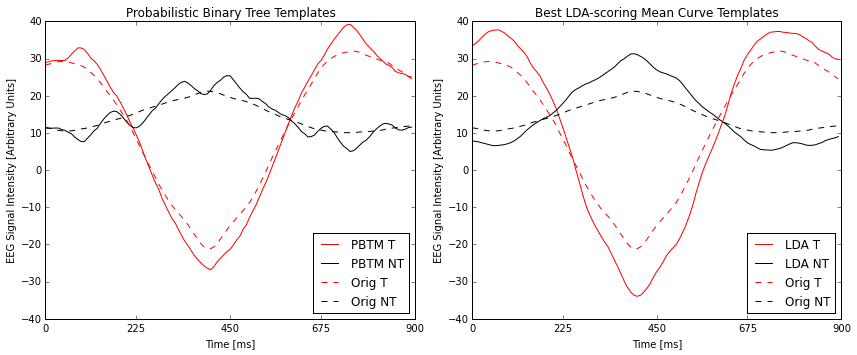

In [7]:

plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.title("Probabilistic Binary Tree Templates")
plt.plot(pbtm_temps[:, 0], label = "PBTM T", color = "red")
plt.plot(pbtm_temps[:, 1], label = "PBTM NT", color = "black")
plt.plot(np.average(trg, axis = 1), "--", label = "Orig T", color = "red")
plt.plot(np.average(ntrg, axis = 1), "--", label = "Orig NT", color = "black")
plt.legend(loc = 4)
#plt.yticks([])
#plt.xticks([])
plt.xlim(0, trg.shape[0])
plt.ylim(-40, 40)
plt.xlabel("Time [ms]")
plt.ylabel("EEG Signal Intensity [Arbitrary Units]")
plt.xticks(np.linspace(0, pbtm_temps.shape[0], 5).astype(int), np.linspace(0, 900, 5).astype(int))

#plt.xticks(np.round(np.linspace(0, synced_targ.shape[0]+1, len(epo_times))), epo_times)


plt.subplot(1,2,2)
plt.title("Best LDA-scoring Mean Curve Templates")
plt.plot(lda_best_curves[:, 0], label = "LDA T", color = "red")
plt.plot(lda_best_curves[:, 1], label = "LDA NT", color = "black")
plt.plot(np.average(trg, axis = 1), "--", label = "Orig T", color = "red")
plt.plot(np.average(ntrg, axis = 1), "--", label = "Orig NT", color = "black")
plt.legend(loc = 4)
plt.xlim(0, trg.shape[0])
plt.ylim(-40, 40)
#plt.yticks([])
plt.xticks(np.linspace(0, len(lda_best_curves[:, 0]), 5).astype(int), np.linspace(0, 900, 5).astype(int))
plt.xlabel("Time [ms]")
plt.ylabel("EEG Signal Intensity [Arbitrary Units]")
#plt.xticks(np.round(np.linspace(0, synced_targ.shape[0]+1, len(epo_times))), epo_times)
#np.linspace()
plt.tight_layout()
plt.savefig("fig4.png")
plt.show()

Figure 5: Classification results bar chart

In [8]:
classification = loadmat("classification_huseyin.mat")

sems_all = classification["sems_all"]
losses_all = classification["losses_all"]
test_names = classification["test_names"]

sems_benchmark = classification["sems_benchmark"]
losses_benchmark = classification["losses_benchmark"]
benchmark_names = classification["benchmark_names"]

In [9]:
print benchmark_names
print losses_all

[[ array([ u'alignedClassification4_1iter_multivar_cow_RLDAshrink_scaling_words_f_xval'], 
      dtype='<U73')]
 [ array([ u'alignedClassification4_1iter_multivar_cow_RLDAshrink_scaling_words_mult_xval'], 
      dtype='<U76')]
 [array([u'RLDAshrink_words2resp_xval'], 
      dtype='<U26')]
 [array([u'RLDAshrink_words_f_xval'], 
      dtype='<U23')]]
[[ 0.19477606  0.21392628  0.2109436   0.21413993  0.21592549  0.21321104]
 [ 0.1715246   0.18607285  0.1875738   0.14536948  0.17732036  0.1837971 ]
 [ 0.12927062  0.14026365  0.13636624  0.14242664  0.1264669   0.14243631]
 [ 0.33634995  0.35977575  0.32676963  0.3391718   0.328334    0.36205754]
 [ 0.19471177  0.22759851  0.22753189  0.20356521  0.18147023  0.2184961 ]
 [ 0.14332271  0.14044848  0.13904155  0.14199388  0.13120682  0.14200108]]


(0, 8, 'Optimal', 0.17235730260493753, 'blue')
(1, 7, 'M-BM', 0.18978213347978767, 'blue')
(2, 4, 'M-LDA-SC50', 0.19345396647524718, 'brown')
(3, 0, 'M-PBTM', 0.19499261785101665, 'brown')
(4, 3, 'M-LDA-SC10', 0.19777782455212364, 'brown')
(5, 2, 'LDA-SC10', 0.20470445319692746, 'brown')
(6, 6, 'BM', 0.20561022655995717, 'blue')
(7, 5, 'LDA-SC50', 0.21033319628051617, 'brown')
(8, 1, 'PBTM', 0.21134758635710749, 'brown')
(9, 9, 'Non-sync', 0.22649561458193254, 'blue')


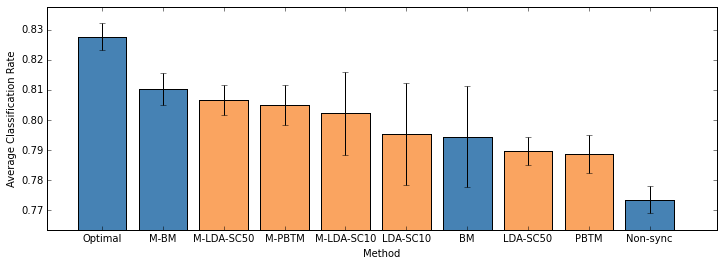

In [10]:
plt.figure(figsize = (12,4))
#plt.show()

test_ids = np.ones(len(test_names))
benchmark_ids = np.zeros(len(benchmark_names))
ids = np.concatenate((test_ids, benchmark_ids))
losses = np.concatenate((np.average(losses_all, axis = 0), np.average(losses_benchmark, axis = 0)))
sems = np.concatenate((np.average(sems_all, axis = 0), np.average(sems_benchmark, axis = 0)))

test_ticks = ["M-PBTM", "PBTM", "LDA-SC10", "M-LDA-SC10", "M-LDA-SC50", "LDA-SC50"]
benchmark_ticks = ["BM", "M-BM", "Optimal", "Non-sync"]
names = np.concatenate((test_ticks, benchmark_ticks))

#print ids, losses, sems

inds_sorted = np.argsort(losses)


for i, j in enumerate(inds_sorted):
    if ids[j] == 0:
        plt.bar(i, 1 - losses[j], color = "steelblue", ecolor = "black", yerr = sems[j]*2)
        print(i, j, names[j], losses[j], 'blue', )
    if ids[j] == 1:
        plt.bar(i, 1 - losses[j], color = "sandybrown", ecolor = "black", yerr = sems[j]*2)
        print(i, j, names[j], losses[j], 'brown')
        

plt.xticks(np.arange(len(names))+0.4, names[inds_sorted])
plt.xlim(-0.5, len(names)+0.5)
plt.ylim(np.min(1 - losses) - 0.01, np.max(1 - losses) + 0.01)
plt.xlabel("Method")
plt.ylabel("Average Classification Rate")

plt.savefig("fig5.png")
plt.show()

In [11]:
ntrg.shape[1] + trg.shape[1]

2000

# Optional figures

Optional figure 1: Feature functions of real EEG curves

Optional figure 2: Breaking down MBS with noise

Optional figure 3: Breaking MBS down with local distortions in time warping